In [1]:
import kagglehub

path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease


In [2]:
import os
from PIL import Image

data_path = os.path.join(path, 'PlantVillage')

for root, dirs, files in os.walk(data_path):
    for file in files:
        filepath = os.path.join(root, file)
        try:
            img = Image.open(filepath)
            img.verify()
        except Exception as e:
            print(f"Skipping corrupted or invalid file: {filepath} - Error: {e}")

Skipping corrupted or invalid file: /kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c - Error: cannot identify image file '/kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'


In [3]:
from sklearn.model_selection import train_test_split
import shutil
import os
from PIL import Image

data_dir = os.path.join(path, 'PlantVillage')
classes = os.listdir(data_dir)


if os.path.exists("dataset"):
    shutil.rmtree("dataset")

os.makedirs("dataset/train", exist_ok=True)
os.makedirs("dataset/val", exist_ok=True)
os.makedirs("dataset/test", exist_ok=True)

print(f"Processing {len(classes)} potential classes...")

total_copied_files = 0

for cls in classes:

    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        imgs = os.listdir(cls_path)

        valid_imgs = []
        for img_name in imgs:
            src_path = os.path.join(cls_path, img_name)
            if os.path.isfile(src_path):
                try:
                    img = Image.open(src_path)

                    img.convert('RGB')
                    valid_imgs.append(img_name)
                except Exception as e:
                    print(f"Skipping corrupted or invalid file during split: {src_path} - Error: {e}")

        if not valid_imgs:
            print(f"No valid images found for class: {cls}, skipping.")
            continue

        print(f"Found {len(valid_imgs)} valid images for class: {cls}")

        train, temp = train_test_split(valid_imgs, test_size=0.4, random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)

        for folder, files in [("train", train), ("val", val), ("test", test)]:
            target_dir = os.path.join(f"dataset/{folder}", cls)
            os.makedirs(target_dir, exist_ok=True)
            for f in files:

                src_path = os.path.join(cls_path, f)
                shutil.copy(src_path, os.path.join(target_dir, f))
                total_copied_files += 1

print(f"Successfully copied a total of {total_copied_files} files to the dataset directories.")


Processing 15 potential classes...
Found 997 valid images for class: Pepper__bell___Bacterial_spot
Found 152 valid images for class: Potato___healthy
Found 952 valid images for class: Tomato_Leaf_Mold
Skipping corrupted or invalid file during split: /kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c - Error: cannot identify image file '/kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c'
Found 3208 valid images for class: Tomato__Tomato_YellowLeaf__Curl_Virus
Found 2127 valid images for class: Tomato_Bacterial_spot
Found 1771 valid images for class: Tomato_Septoria_leaf_spot
Found 1591 valid images for class: Tomato_healthy
Found 1676 valid images for class: Tomato_Spider_mites_Two_spotted_spider_mite
Found 1000 valid images for class: Tomato_Early_blight
Found 1404 valid images for class: Tomato__Target_Spot
Found 1478 valid images for class: Pepper__bell___healthy
Found 1000 valid images for class: Potato___La

In [4]:
import torchvision.transforms as transforms

train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])


In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os


print("Checking directory structure for dataset/train:")
root_dir_to_check = "dataset/train"
if os.path.exists(root_dir_to_check):
    for item in os.listdir(root_dir_to_check):
        item_path = os.path.join(root_dir_to_check, item)
        if os.path.isdir(item_path):
            print(f"  - Directory: {item}")

            if item == 'PlantVillage' and os.path.isdir(item_path):
                print(f"    Contents of {item_path}:")
                for sub_item in os.listdir(item_path):
                    print(f"      - {sub_item}")
        else:
            print(f"  - File: {item}")
else:
    print(f"Directory {root_dir_to_check} does not exist.")
print("--- Diagnostic Code End ---")


train_ds = ImageFolder("dataset/train", transform=train_tf)
val_ds   = ImageFolder("dataset/val",   transform=val_test_tf)
test_ds  = ImageFolder("dataset/test",  transform=val_test_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)


num_classes = len(train_ds.classes)
print(f"Number of classes: {num_classes}")

Checking directory structure for dataset/train:
  - Directory: Tomato_Leaf_Mold
  - Directory: Tomato__Tomato_mosaic_virus
  - Directory: Potato___Late_blight
  - Directory: Tomato_Early_blight
  - Directory: Tomato_healthy
  - Directory: Potato___healthy
  - Directory: Tomato_Spider_mites_Two_spotted_spider_mite
  - Directory: Tomato_Bacterial_spot
  - Directory: Tomato_Late_blight
  - Directory: Tomato__Tomato_YellowLeaf__Curl_Virus
  - Directory: Pepper__bell___healthy
  - Directory: Potato___Early_blight
  - Directory: Tomato_Septoria_leaf_spot
  - Directory: Tomato__Target_Spot
  - Directory: Pepper__bell___Bacterial_spot
--- Diagnostic Code End ---
Number of classes: 15


In [6]:
num_epochs = 3
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

In [7]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

model.fc = nn.Linear(2048, num_classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [8]:
from tqdm.auto import tqdm

for epoch in range(num_epochs):

    model.train()
    running_loss = 0
    correct = 0
    total = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loop.set_postfix(loss=running_loss/total, acc=correct/total)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)

    # validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():

        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        for inputs, labels in val_loop:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            val_loop.set_postfix(loss=val_loss/val_total, acc=val_correct/val_total)

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total

    val_loss_list.append(val_epoch_loss)
    val_acc_list.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"- Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} "
          f"- Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

Epoch 1/3 [Train]:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 1/3 [Validation]:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch [1/3] - Train Loss: 0.3591 Acc: 0.8875 - Val Loss: 0.4288 Acc: 0.8687


Epoch 2/3 [Train]:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 2/3 [Validation]:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch [2/3] - Train Loss: 0.1222 Acc: 0.9594 - Val Loss: 0.1118 Acc: 0.9641


Epoch 3/3 [Train]:   0%|          | 0/387 [00:00<?, ?it/s]

Epoch 3/3 [Validation]:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch [3/3] - Train Loss: 0.1021 Acc: 0.9661 - Val Loss: 0.1143 Acc: 0.9620


In [9]:
best_path = "best_model.pth"
torch.save(model.state_dict(), best_path)

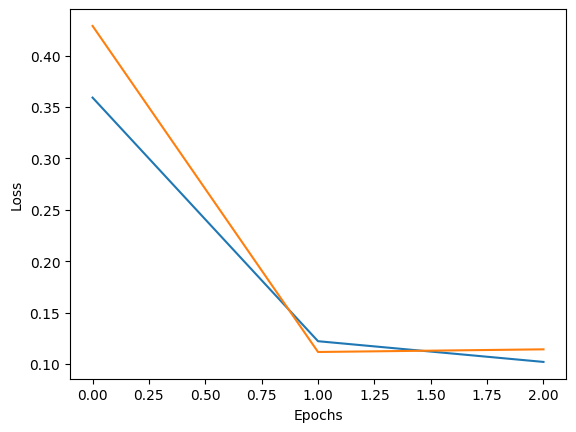

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
